## Reproduce Published results with Starfish

This notebook walks through a workflow that reproduces a MERFISH result for one field of view using the starfish package.

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import pprint
import time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import scoreatpercentile

from showit import image, tile
from starfish.constants import Indices
from starfish.io import Stack
from starfish.viz import tile_lims

%matplotlib inline

In [3]:
# load the data from cloudfront
s = Stack()
s.read('https://dmf0bdeheu4zf.cloudfront.net/20180710/MERFISH/fov_001/experiment.json')

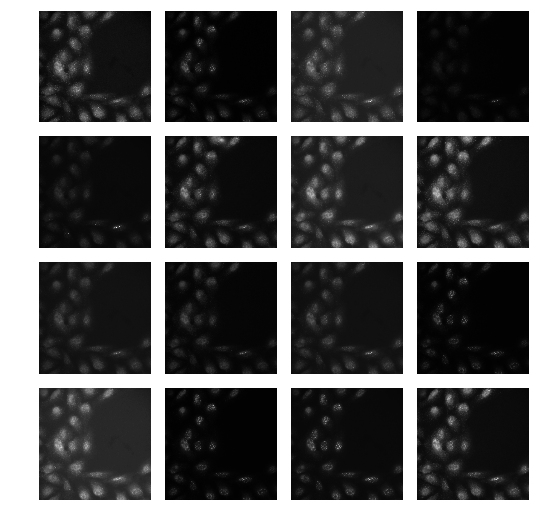

In [4]:
# data from one FOV correspond to 16 single plane images as shown here (see below for details)
tile(s.image.squeeze());

Individual hybridization rounds and channels can also be visualized

In [5]:
# show all hybridization rounds of channel 0
s.image.show_stack({Indices.CH: 0}, rescale=False)

interactive(children=(IntSlider(value=0, description='plane_index', max=7), Output()), _dom_classes=('widget-i…

<function starfish.image._stack.ImageStack.show_stack.<locals>.display_slice(plane_index=0)>

## Show input file format that specifies how the tiff stack is organized

The stack contains multiple images corresponding to the channel and hybridization round. MERFISH builds a 16 bit barcode from 8 hybridization rounds, each of which measures two channels that correspond to contiguous (but not necessarily consistently ordered) bits of the barcode. 

The MERFISH computational pipeline also constructs a scalar that corrects for intensity differences across each of the 16 images, e.g., one scale factor per bit position.

The stacks in this example are pre-registered using fiduciary beads. 

In [6]:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(s.org)

{ 'auxiliary_images': {'nuclei': 'nuclei.json'},
  'hybridization_images': 'hybridization.json',
  'version': '0.0.0'}


## Visualize codebook

The MERFISH codebook maps each barcode to a gene (or blank) feature. The codes in the MERFISH codebook are constructed from a 4-hamming error correcting code with exactly 4 "on" bits per barcode

In [7]:
from starfish.codebook import Codebook
codebook = Codebook.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180710/MERFISH/codebook.json')
codebook

<xarray.Codebook (gene_name: 140, c: 2, h: 8)>
array([[[0, 1, ..., 1, 0],
        [0, 1, ..., 0, 0]],

       [[1, 1, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [1, 0, ..., 0, 0]],

       [[1, 0, ..., 0, 0],
        [1, 0, ..., 0, 0]]], dtype=uint8)
Coordinates:
  * gene_name  (gene_name) object 'Blank-1' 'Blank-10' 'Blank-2' 'Blank-3' ...
  * c          (c) int64 0 1
  * h          (h) int64 0 1 2 3 4 5 6 7

## Filter and scale raw data before decoding

In [8]:
from starfish.pipeline.filter.gaussian_high_pass import GaussianHighPass
from starfish.pipeline.filter.gaussian_low_pass import GaussianLowPass
from starfish.pipeline.filter.richardson_lucy_deconvolution import DeconvolvePSF
from starfish.viz import tile_lims

Begin filtering with a high pass filter to remove background signal.

In [9]:
from starfish.pipeline.filter.gaussian_high_pass import GaussianHighPass
ghp = GaussianHighPass(sigma=3, verbose=True)
ghp.filter(s.image)

16it [00:03,  5.25it/s]


The below algorithm deconvolves out the point spread function introduced by the microcope and is specifically designed for this use case. The number of iterations is an important parameter that needs careful optimization. 

In [10]:
from starfish.pipeline.filter.richardson_lucy_deconvolution import DeconvolvePSF
dpsf = DeconvolvePSF(num_iter=15, sigma=2, verbose=True)
dpsf.filter(s.image)

16it [03:32, 13.29s/it]


Recall that the image is pre-registered, as stated above. Despite this, individual RNA molecules may still not be perfectly aligned across hybridization rounds. This is crucial in order to read out a measure of the itended barcode (across hybridization rounds) in order to map it to the codebook. To solve for potential mis-alignment, the images can be blurred with a 1-pixel Gaussian kernel. The risk here is that this will obfuscate signals from nearby molecules. 

A local search in pixel space across hybridization rounds can also solve this. 

In [11]:
from starfish.pipeline.filter.gaussian_low_pass import GaussianLowPass
glp = GaussianLowPass(sigma=1, verbose=True)
glp.filter(s.image)

16it [00:02,  7.42it/s]


Use MERFISH-calculated size factors to scale the channels across the hybridization rounds and visualize the resulting filtered and scaled images. Right now we have to extract this information from the metadata and apply this transformation manually.

In [12]:
scale_factors = {(t[Indices.HYB], t[Indices.CH]): t['scale_factor'] for index, t in s.image.tile_metadata.iterrows()}

In [13]:
# this is a scaling method. It would be great to use image.apply here. It's possible, but we need to expose H & C to 
# at least we can do it with get_slice and set_slice right now.

for indices in s.image._iter_indices():
    data = s.image.get_slice(indices)[0]
    scaled = data / scale_factors[indices[Indices.HYB.value], indices[Indices.CH.value]]
    s.image.set_slice(indices, scaled)

In [14]:
from scipy.stats import scoreatpercentile

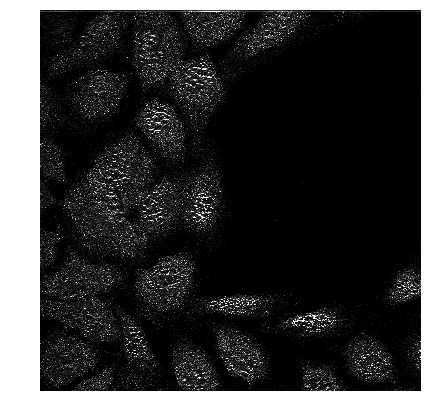

In [15]:
mp = s.image.max_proj(Indices.HYB.value, Indices.CH.value, Indices.Z.value)
clim = scoreatpercentile(mp, [0.5, 99.5])
image(mp, clim=clim)

## Use spot-detector to create 'encoder' table  for standardized input  to decoder

Each pipeline exposes a spot detector, and this spot detector translates the filtered image into an encoded table by detecting spots. The table contains the spot_id, the corresponding intensity (val) and the channel (ch), hybridization round (hyb), and bit position (bit) of each spot. 

The MERFISH pipeline merges these two steps together by finding pixel-based features, and then later collapsing these into spots and filtering out undesirable (non-spot) features. 

Therefore, no encoder table is generated, but a robust SpotAttribute and DecodedTable are both produced:

## Decode

Each assay type also exposes a decoder. A decoder translates each spot (spot_id) in the encoded table into a gene that matches a barcode in the codebook. The goal is to decode and output a quality score, per spot, that describes the confidence in the decoding. Recall that in the MERFISH pipeline, each 'spot' is actually a 16 dimensional vector, one per pixel in the image. From here on, we will refer to these as pixel vectors. Once these pixel vectors are decoded into gene values, contiguous pixels that are decoded to the same gene are labeled as 'spots' via a connected components labeler. We shall refer to the latter as spots.

There are hard and soft decodings -- hard decoding is just looking for the max value in the code book. Soft decoding, by contrast, finds the closest code by distance in intensity. Because different assays each have their own intensities and error modes, we leave decoders as user-defined functions. 

For MERFISH, which uses soft decoding, there are several parameters which are important to determining the result of the decoding method: 

### Distance threshold
In MERFISH, each pixel vector is a 16d vector that we want to map onto a barcode via minimum euclidean distance. Each barcode in the codebook, and each pixel vector is first mapped to the unit sphere by L2 normalization. As such, the maximum distance between a pixel vector and the nearest single-bit error barcode is 0.5176. As such, the decoder only accepts pixel vectors that are below this distance for assignment to a codeword in the codebook. 

### Magnitude threshold
This is a signal floor for decoding. Pixel vectors with an L2 norm below this floor are not considered for decoding. 

### Area threshold
Contiguous pixels that decode to the same gene are called as spots via connected components labeling. The minimum area of these spots are set by this parameter. The intuition is that pixel vectors, that pass the distance and magnitude thresholds, shold probably not be trusted as genes as the mRNA transcript would be too small for them to be real. This parameter can be set based on microscope resolution and signal amplification strategy.

### Crop size 
The crop size crops the image by a number of pixels large enough to eliminate parts of the image that suffer from boundary effects from both signal aquisition (e.g., FOV overlap) and image processing. Here this value is 40.

Given these three thresholds, for each pixel vector, the decoder picks the closest code (minimum distance) that satisfies each of the above thresholds, where the distance is calculated between the code and a normalized intensity vector and throws away subsequent spots that are too small.

In [16]:
from starfish.pipeline.features.pixels.pixel_spot_detector import PixelSpotDetector
psd = PixelSpotDetector(
    codebook=codebook,
    distance_threshold=0.5176,
    magnitude_threshold=1,
    min_area=2,
    max_area=np.inf,
    norm_order=2, 
    crop_size=(0, 40, 40)
)

spot_intensities, prop_results = psd.find(s.image)
spot_intensities

<xarray.IntensityTable (features: 20086, c: 2, h: 8)>
array([[[0.      , 1.      , ..., 0.      , 0.      ],
        [0.      , 1.      , ..., 0.      , 0.      ]],

       [[1.333333, 2.      , ..., 0.      , 0.      ],
        [0.666667, 4.333333, ..., 0.      , 0.      ]],

       ...,

       [[0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 2.      ]],

       [[1.      , 4.      , ..., 0.      , 1.      ],
        [0.      , 1.      , ..., 0.      , 2.5     ]]])
Coordinates:
  * features   (features) MultiIndex
  - gene_name  (features) object 'SCUBE3' 'SCUBE3' 'SCUBE3' 'TSTD2' 'None' ...
  - radius     (features) float64 0.7979 0.9772 1.128 1.128 1.693 3.385 ...
  - x          (features) int64 752 1323 1356 458 16 40 71 138 166 186 202 ...
  - y          (features) int64 3 3 3 5 7 7 7 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...
  - z          (features) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - distance   (features) float64 0.5001 

## Compare to results from paper 

The below plot aggregates gene copy number across single cells in the field of view and compares the results to the published intensities in the MERFISH paper. 

To make this match perfectly, run deconvolution 15 times instead of 14. As presented below, STARFISH displays a lower detection rate.  

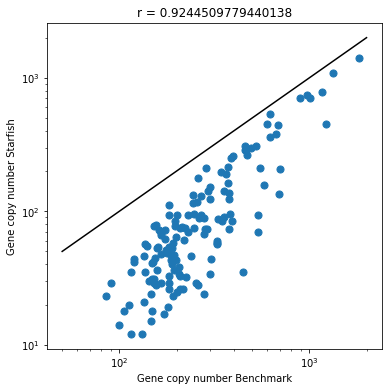

In [33]:
bench = pd.read_csv('https://dmf0bdeheu4zf.cloudfront.net/MERFISH/benchmark_results.csv', 
                    dtype = {'barcode':object})

benchmark_counts = bench.groupby('gene')['gene'].count()
genes, counts = np.unique(spot_intensities.gene_name, return_counts=True)
result_counts = pd.Series(counts, index=genes)

tmp = pd.concat([result_counts, benchmark_counts], join='inner', axis=1).values

r = np.corrcoef(tmp[:, 1], tmp[:, 0])[0, 1]
x = np.linspace(50, 2000)
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(tmp[:, 1], tmp[:, 0], 50, zorder=2)
ax.plot(x, x, '-k', zorder=1)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.xscale('log')
plt.yscale('log')
plt.title(f'r = {r}');

## Visualize results

This image applies a pseudo-color to each gene channel to visualize the position and size of all called spots in a subset of the test image

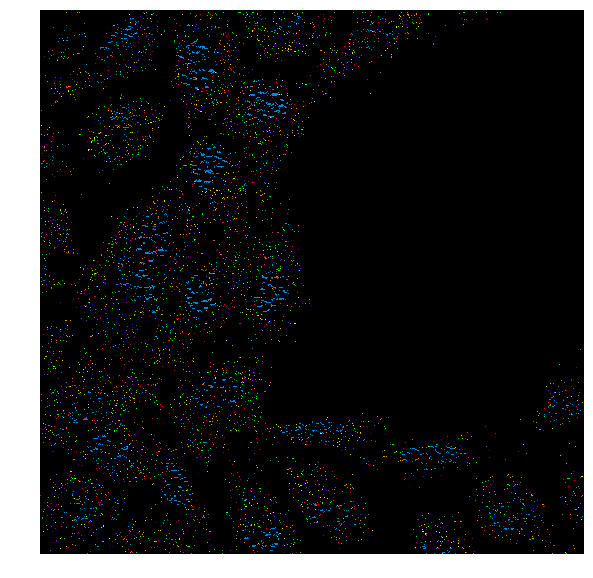

In [18]:
area_lookup = lambda x: 0 if x == 0 else prop_results.region_properties[x - 1].area
vfunc = np.vectorize(area_lookup)
mask = np.squeeze(vfunc(prop_results.label_image))
image((np.squeeze(prop_results.decoded_image)*(mask > 2)), cmap = 'nipy_spectral', size=10)